### tag+DL+Attention
这是论文TRSDL的实现及改进
这里的改进是添加如论文《A Reccurent Neural Network Based Recommendation System》

因为没有额外的数据来训练tag的潜入特征，这里是直接用标签和项目的属性进行的训练，训练采用的包是gensim的word2vec
使用tag作为attention的query



In [1]:
import time
from datetime import datetime

import pandas as pd
import numpy as np

import os
import re

import tensorflow as tf
import logging

import gensim 

from gensim.test.utils import get_tmpfile
from gensim.models import Word2Vec

import matplotlib.pyplot as plt

c:\users\yxr\anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## 准备数据阶段

In [ ]:
tag_data = pd.read_csv('../ml-20m/tags.csv')

tag_data.dropna(inplace=True)

tag_data.sort_values('timestamp', inplace=True)

### 去除使用次数少于一次的标签 

In [ ]:
# tag_count = tag_data.tag.value_counts()

# tag_data = pd.merge(tag_data, tag_count.to_frame(), left_on='tag', right_index=True).drop(['tag_x'], axis=1)

# tag_data.rename(columns={'tag_y':'tag_count'}, inplace=True)

# tag_data = tag_data[tag_data.tag_count > 1]

In [ ]:
tag_data.head()

In [ ]:
print('打过tag的用户总数：', len(tag_data.userId.unique()))
print('打过tag的电影总数：', len(tag_data.movieId.unique()))
print('标签总数', len(tag_data.tag.unique()))

In [ ]:
def train_test_split(data, test_rate=0.2):
    user_ids = data.userId.unique()
    test = []
    train = []
    for uid in user_ids:
        u_data = data[data.userId == uid].sort_values('timestamp')
        if len(u_data) > 1/test_rate:
            train.append(u_data[:int(len(u_data)*(1-test_rate))])
            test.append(u_data[int(len(u_data)*(1-test_rate)):])
        else:
            train.append(u_data)
    return pd.concat(train), pd.concat(test)
        

In [ ]:
train_data , test_data = train_test_split(tag_data)

### 获取对应的评分数据用于训练 

In [ ]:
rating_data = pd.read_csv('../ml-20m/ratings.csv')

train_pairs = train_data.apply(lambda x : (x['userId'], x['movieId']), axis=1)

test_pairs = test_data.apply(lambda x : (x['userId'], x['movieId']), axis=1)

rating_data = rating_data[rating_data.userId.isin(train_data.userId.unique())]

rating_data['pairs'] = rating_data.apply(lambda x : (x['userId'], x['movieId']), axis=1)

train = rating_data[rating_data.pairs.isin(train_pairs)]

test = rating_data[rating_data.pairs.isin(test_pairs)]

### 将数据序列化至硬盘，方便下次直接读取 

In [ ]:
train.to_csv('train_rating.data')
test.to_csv('test_rating.data')

train_data.sort_values('timestamp').to_csv('train.data', encoding='utf-8')

test_data.sort_values('timestamp').to_csv('test.data', encoding='utf-8')

### 直接读取训练测试集数据 

In [2]:
train_data = pd.read_csv('train.data')
test_data = pd.read_csv('test.data')

train = pd.read_csv('train_rating.data')
test = pd.read_csv('test_rating.data')

In [3]:
def print_info(data):
    print('用户总数：', len(data.userId.unique()))
    print('电影总数：', len(data.movieId.unique()))
    #print('标签总数', len(data.tag.unique()))

In [4]:
print_info(train)

用户总数： 7148
电影总数： 12119


In [5]:
train_data.head()

,Unnamed: 0,userId,movieId,tag,timestamp
0,333932,100371,2788,monty python,1135429210
1,333927,100371,1732,coen brothers,1135429236
2,333924,100371,1206,stanley kubrick,1135429248
3,333923,100371,1193,jack nicholson,1135429371
4,333939,100371,5004,peter sellers,1135429399


In [6]:
def parse_tag(val):
    '''处理标签'''
    #print(val)
    pattern = re.compile(r'\w+|\d+')
    word_list = pattern.findall(val)
    return ' '.join(word_list)
train_data['tag'] = train_data.tag.map(parse_tag)

In [7]:
train_data.head()

,Unnamed: 0,userId,movieId,tag,timestamp
0,333932,100371,2788,monty python,1135429210
1,333927,100371,1732,coen brothers,1135429236
2,333924,100371,1206,stanley kubrick,1135429248
3,333923,100371,1193,jack nicholson,1135429371
4,333939,100371,5004,peter sellers,1135429399


In [8]:
def aggregate_tags(group):
    '''将同一电影的标签聚合'''
    tags = ''
    for tag in group['tag']:
        tags+='|'+tag
    return tags
movie_tags = train_data[['tag','movieId']].groupby(['movieId']).apply(aggregate_tags)

### 根据电影数据学习标签的word2vec嵌入

In [9]:
movie_tags.to_frame().head()

,0
movieId,
1,|the boys|classic|pixar|Disney|pixar|cgi|anima...
2,|monkey|For children|game|animals|kid flick|Fa...
3,|Funniest Movies|sequel fever|comedinha de vel...
4,|characters
5,|family|sequel|wedding|remake|pregnancy|sequel...


In [10]:
movie_data = pd.read_csv('../ml-20m/movies.csv')

### 电影的名字作为

In [11]:

# def parse_name(val):
#     pattern = re.compile(r'^(.*)\(\d+\)$')
#     if pattern.match(val):
#         return pattern.match(val).group(1)
#     else:
#         return None
# def parse_time(val):
#     pattern = re.compile(r'^.*\((\d+)\)$')
#     if pattern.match(val):
#         return pattern.match(val).group(1)
#     else:
#         return None
# movie_data['name']= movie_data.title.map(parse_name )
# movie_data['publish']= movie_data.title.map( parse_time)

# #有一行发现name没有解析到，手动添加好了
# movie_data.loc[9773,'name'] = 'Sister Helen'
# movie_data.loc[9773,'publish'] = '2002'

In [12]:
movie_data = pd.merge(movie_data, movie_tags.to_frame(), left_on='movieId',how='left', right_index=True)

movie_data.rename(columns={0:'tags'}, inplace=True)

In [13]:
movie_data.head()

,movieId,title,genres,tags
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,|the boys|classic|pixar|Disney|pixar|cgi|anima...
1,2,Jumanji (1995),Adventure|Children|Fantasy,|monkey|For children|game|animals|kid flick|Fa...
2,3,Grumpier Old Men (1995),Comedy|Romance,|Funniest Movies|sequel fever|comedinha de vel...
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,|characters
4,5,Father of the Bride Part II (1995),Comedy,|family|sequel|wedding|remake|pregnancy|sequel...


In [14]:
movie_data.tags.fillna('', inplace=True)

In [15]:
#将所有可以拿来做word2vec的条目进行整合
movie_data['words'] = movie_data.apply(lambda x :x['genres']+x['tags'], axis=1)
movie_data.words = movie_data.words.map(str.lower)

In [16]:
movie_data.head()

,movieId,title,genres,tags,words
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,|the boys|classic|pixar|Disney|pixar|cgi|anima...,adventure|animation|children|comedy|fantasy|th...
1,2,Jumanji (1995),Adventure|Children|Fantasy,|monkey|For children|game|animals|kid flick|Fa...,adventure|children|fantasy|monkey|for children...
2,3,Grumpier Old Men (1995),Comedy|Romance,|Funniest Movies|sequel fever|comedinha de vel...,comedy|romance|funniest movies|sequel fever|co...
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,|characters,comedy|drama|romance|characters
4,5,Father of the Bride Part II (1995),Comedy,|family|sequel|wedding|remake|pregnancy|sequel...,comedy|family|sequel|wedding|remake|pregnancy|...


### 直接读取训练好的数据 

In [17]:
from gensim.models import KeyedVectors

In [18]:
kvmodel = KeyedVectors.load('wordvectors.kv')

### 创建标签嵌入字典

In [19]:
tags = train_data.tag.unique()

In [20]:
tag_dictionary = {}
tag_reverse_dict = {}
tag_embedding_dict = {}

In [21]:
def get_tag_embed(tag, wordvectors):
    word_list = parse_tag(tag).split(' ')
    embed_list = []
    for word in word_list:
        word = word.lower()
        try:
            embed =wordvectors[word]
        except Exception as e:
            print(tag, e)
        else:
            embed_list.append(embed)
    return sum(embed_list)/len(embed_list)

In [22]:
for key,value in enumerate(tags):
    tag_dictionary[key] = value
    tag_reverse_dict[value] = key
    tag_embedding_dict[key] = get_tag_embed(value, kvmodel)

### 准备用于训练的用户标签数据
因为得到的用户特征应该是从用户的历史标签数据获得的，所以训练的用户都应该是进行过tag行为的用户。

In [23]:
train_data['tag_id'] = train_data.tag.map(lambda x : tag_reverse_dict[x])

In [24]:
train_data.head()

,Unnamed: 0,userId,movieId,tag,timestamp,tag_id
0,333932,100371,2788,monty python,1135429210,0
1,333927,100371,1732,coen brothers,1135429236,1
2,333924,100371,1206,stanley kubrick,1135429248,2
3,333923,100371,1193,jack nicholson,1135429371,3
4,333939,100371,5004,peter sellers,1135429399,4


这里在整理用户的标签的时候，一定要注意按照时间顺序进行排列，方便后续直接选择最新的L条数据

### 获取电影嵌入层 数据

In [25]:
def word2embed(words, wordectors):
    word_list = ' '.join(words.split('|'))
    word_list =[word for word in word_list.split(' ') if word ]
    embed_list = []
    for word in word_list:
        try:
            embed_word = wordectors[word]
        except Exception as e:
            print(words,e)
        embed_list.append(embed_word)
    return sum(embed_list)/len(embed_list)
movie_data['embedding'] = movie_data[['movieId', 'words']].words.map(lambda x : word2embed(x, kvmodel))

In [26]:
def get_item_embedding(movie_ids, movie_data):
    embed_list = []
    for iid in movie_ids:
        embed_list.append(movie_data[movie_data.movieId == iid]['embedding'].values[0])
    return np.vstack(embed_list)

###  获取用户的序列数据
要放入LSTM中训练，所需要的数据需要特别处理成[L, batch_size, embed_size ]

In [27]:
def get_itemid_and_tagid(uid, train_data):
    uid_df = train_data[train_data.userId==uid].sort_values('timestamp')
    itemids = uid_df.movieId.values
    tagids = uid_df.tag_id.values
    return itemids, tagids

In [28]:
movie_data.head()

,movieId,title,genres,tags,words,embedding
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,|the boys|classic|pixar|Disney|pixar|cgi|anima...,adventure|animation|children|comedy|fantasy|th...,"[1.3463397, 0.6780038, 0.2851267, -1.0600985, ..."
1,2,Jumanji (1995),Adventure|Children|Fantasy,|monkey|For children|game|animals|kid flick|Fa...,adventure|children|fantasy|monkey|for children...,"[1.2482871, -0.17743495, -0.0875407, -0.451083..."
2,3,Grumpier Old Men (1995),Comedy|Romance,|Funniest Movies|sequel fever|comedinha de vel...,comedy|romance|funniest movies|sequel fever|co...,"[0.5747506, 0.15034838, 0.07378666, -0.1128338..."
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,|characters,comedy|drama|romance|characters,"[1.1935364, 0.8308131, -0.42819518, -0.5645936..."
4,5,Father of the Bride Part II (1995),Comedy,|family|sequel|wedding|remake|pregnancy|sequel...,comedy|family|sequel|wedding|remake|pregnancy|...,"[0.8471681, 0.3690049, 0.1280702, -0.17328389,..."


In [29]:
get_itemid_and_tagid(100371, train_data)

(array([ 2788,  1732,  1206,  1193,  5004,    47,    47,  4011,  4011,
           32,  2858,  2329,  2329,  6016,  5294,  3168,  3168,  4082,
         1884,  1884,  1208,  6003,  6679,  7008, 41569,  1500, 41997,
            6, 33171, 38600, 27846, 27846], dtype=int64),
 array([   0,    1,    2,    3,    4,    5,    6,    5,    7,    8,    9,
          10,   11,   12,   20,   64,   63,   70,   24,   71,   72,   73,
          74,  993, 1850, 2057, 1850, 2265, 2743, 5151, 1018,   55],
       dtype=int64))

In [30]:
movie_df = movie_data[['movieId', 'embedding']].set_index('movieId')

In [31]:
def get_tags_embedding(tag_ids, tag_embedding_dict):
    tag_embeddings = []
    for tid in tag_ids:
        if tid == -1:
            tag_embeddings.append(np.zeros(embed_size))
        else:
            tag_embeddings.append(tag_embedding_dict[tid])
        return np.vstack(tag_embeddings)
        

In [32]:
def get_user_embeding(user_ids, L, train_data, movie_df, tag_embedding_dict):
    global batch_size
    embeddings = []
    tag_embeddings = []
    for i in  range(L):
        user_embed = []
        tag_embed = []
        for uid in user_ids:
            user_movie_tag  = []
            itemids, tagids = get_itemid_and_tagid(uid, train_data)
            if i+1 > len(itemids):
                user_embed.append(np.zeros(embed_size))
                user_movie_tag.append(-1)
            else:
                user_embed.append(movie_df.loc[itemids[-(i+1)], 'embedding' ])
                user_movie_tag.append(tagids[-(i+1)])
            user_movie_tag = list(reversed(user_movie_tag))
            tag_embed.append(get_tags_embedding(user_movie_tag, tag_embedding_dict))
        user_embed = reversed(user_embed)
        tag_embed = reversed(tag_embed)
        embeddings.append(np.vstack(user_embed))
        tag_embeddings.append(np.vstack(tag_embed))
    return np.array(embeddings), np.array(tag_embeddings)

In [34]:
def get_batches(Xs, ys):
    global batch_size
    num = len(Xs)
    for i in range(batch_size):
        select_index = np.random.choice(range(num), size=batch_size, replace=False)
#         print(select_index)
        return  Xs.iloc[select_index, :], ys[select_index]

### 定义数据接口

In [35]:
def get_inputs():
    item_embed_layer = tf.placeholder(tf.float32, shape=[batch_size, embed_size])
    user_embed_layer = tf.placeholder(tf.float32, shape=[L, batch_size, embed_size])
    tag_embed_layer = tf.placeholder(tf.float32, shape=[L, batch_size, embed_size])
    targets = tf.placeholder(tf.float32, [None, 1], name="targets")
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return item_embed_layer, user_embed_layer, targets, learning_rate, tag_embed_layer

### 构建计算图 

In [46]:
L = 3
batch_size = 256
embed_size = 100#前面gensim用的100
lstm_embed = 64

num_steps = 10
learning_rate = 0.001
show_evey_batches = 100

In [47]:
tf.reset_default_graph()
graph =tf.Graph()
with graph.as_default():
    item_embed_layer, user_embed_layer, targets, lr, tag_embed_layer = get_inputs()
    with tf.name_scope('item_layer'):
        item_fc_layer = tf.layers.dense(item_embed_layer, 64, name='fc_layer_1', activation=tf.nn.relu)
    with tf.name_scope('user_layer'):
        lstm = tf.contrib.rnn.BasicLSTMCell(100)
        # Initial state of the LSTM memory.
        state = lstm.zero_state(batch_size, dtype=tf.float32)
        states = []
        for i in range(user_embed_layer.shape[0]):
            # The value of state is updated after processing each batch of words.
            _, state = lstm(user_embed_layer[i], state)
            states.append(state.c)
#             state.c  = tf.layers.dense(tf.concat([state.c, tag_embed_layer[i]], 1),units=64, activation=tf.nn.relu)
            # The LSTM output can be used to make next word predictions
        lstm = tf.contrib.rnn.BasicLSTMCell(64)
        # Initial state of the LSTM memory.
        state = lstm.zero_state(batch_size, dtype=tf.float32)
        for i in range(user_embed_layer.shape[0]):
            # The value of state is updated after processing each batch of words.
#             new_input = tf.layers.dense(tf.concat([states[i],tag_embed_layer[i]], 1), units=100, activation=tf.nn.relu)
            new_input = tf.reduce_mean([states[i], tag_embed_layer[i]], axis=0)
            output, state = lstm(new_input, state)
    with tf.name_scope("inference"):

        inference = tf.reduce_sum(item_fc_layer *output, axis=1)
        inference = tf.expand_dims(inference, axis=1)

    with tf.name_scope("loss"):
        # MSE损失，将计算值回归到评分
        cost = tf.losses.mean_squared_error(targets, inference )
        loss = tf.reduce_mean(cost)
    
    global_step = tf.Variable(0, name="global_step", trainable=False)
    optimizer = tf.train.AdamOptimizer(lr)
    gradients = optimizer.compute_gradients(loss)  #cost
    train_op = optimizer.apply_gradients(gradients, global_step=global_step)

### 训练网络 

In [48]:
def print_log(message, f):
    now = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print(now + ' '+ message)
    print(now + ' '+message, file=f)

In [49]:
losss= {'train':[], 'test': []}
f = open('loss_attentionbase.log', 'a')
print('num_steps:{}, learning_rate:{}, batch_size:{}, embed_size:{}'.format( \
                                num_steps, learning_rate, batch_size, embed_size), file=f)
with tf.Session(graph=graph) as sess:
    tf.global_variables_initializer().run()
    for step in range(num_steps):
        for batch_i in range(len(train)//batch_size):
            x, y = get_batches(train, train['rating'].values.reshape([-1,1]))
            item_embed_data = get_item_embedding(x['movieId'], movie_data)
            user_embed_data, tag_embed_data = get_user_embeding(x['userId'],L, train_data, movie_df, tag_embedding_dict)
            feed_dict = {item_embed_layer:item_embed_data, user_embed_layer:user_embed_data, \
                         targets:np.array(y), lr:learning_rate, tag_embed_layer:tag_embed_data}
            
            step, train_loss, _ = sess.run([global_step, loss, train_op], feed_dict=feed_dict)
            losss['train'].append(train_loss)
            x, y = get_batches(test, test['rating'].values.reshape([-1,1]))
            item_embed_data = get_item_embedding(x['movieId'], movie_data)
            user_embed_data, tag_embed_data = get_user_embeding(x['userId'], L, train_data, movie_df, tag_embedding_dict)
#             print(user_embed_data)
            feed_dict = {item_embed_layer:item_embed_data, user_embed_layer:user_embed_data, \
                         targets:np.array(y), lr:learning_rate, tag_embed_layer:tag_embed_data}
            
            step, test_loss= sess.run([global_step, loss], feed_dict=feed_dict)
            losss['test'].append(test_loss)

            if (step*batch_i) % show_evey_batches == 0:
                print_log('process:{}, L:{}, train_loss_mean:{}, test_loss_mean:{}'.format((step+1)*(batch_i+1), L, \
                                                                    np.mean(losss['train'][-show_evey_batches:]), \
                                                                np.mean(losss['test'][-show_evey_batches:])), f)
            

2018-12-28 14:12:57 process:2, L:3, train_loss_mean:16.540205001831055, test_loss_mean:13.913515090942383
2018-12-28 14:14:01 process:650, L:3, train_loss_mean:5.527456283569336, test_loss_mean:4.926624298095703
2018-12-28 14:16:09 process:5852, L:3, train_loss_mean:2.7520697116851807, test_loss_mean:2.657984733581543
2018-12-28 14:17:09 process:10100, L:3, train_loss_mean:2.3730907440185547, test_loss_mean:2.3299973011016846
2018-12-28 14:17:12 process:10302, L:3, train_loss_mean:2.220348358154297, test_loss_mean:2.203498363494873
2018-12-28 14:18:11 process:15750, L:3, train_loss_mean:1.2640453577041626, test_loss_mean:1.4042608737945557
2018-12-28 14:20:19 process:31152, L:3, train_loss_mean:1.1044920682907104, test_loss_mean:1.2101008892059326
2018-12-28 14:21:19 process:40200, L:3, train_loss_mean:1.0671805143356323, test_loss_mean:1.1676948070526123
2018-12-28 14:21:21 process:40602, L:3, train_loss_mean:1.0667195320129395, test_loss_mean:1.1663801670074463
2018-12-28 14:22:21 pr

2018-12-28 15:07:00 process:1214, L:3, train_loss_mean:0.9223279356956482, test_loss_mean:1.0367025136947632
2018-12-28 15:07:30 process:15938, L:3, train_loss_mean:0.9167510271072388, test_loss_mean:1.0383132696151733
2018-12-28 15:10:12 process:97964, L:3, train_loss_mean:0.9306182861328125, test_loss_mean:1.0198520421981812
2018-12-28 15:10:43 process:114488, L:3, train_loss_mean:0.9386559128761292, test_loss_mean:1.0207117795944214
2018-12-28 15:11:18 process:132714, L:3, train_loss_mean:0.9348678588867188, test_loss_mean:1.0152311325073242
2018-12-28 15:11:53 process:149838, L:3, train_loss_mean:0.9365460276603699, test_loss_mean:1.0104833841323853
2018-12-28 15:14:58 process:244464, L:3, train_loss_mean:0.9295393228530884, test_loss_mean:1.002296805381775
2018-12-28 15:15:29 process:263388, L:3, train_loss_mean:0.9160239696502686, test_loss_mean:0.9980777502059937
2018-12-28 15:16:01 process:284214, L:3, train_loss_mean:0.9238466620445251, test_loss_mean:0.9989364743232727
2018-1

2018-12-28 16:09:08 process:642506, L:3, train_loss_mean:0.9213051795959473, test_loss_mean:1.0134010314941406
2018-12-28 16:09:45 process:686336, L:3, train_loss_mean:0.9183907508850098, test_loss_mean:1.0128649473190308
2018-12-28 16:09:58 process:701046, L:3, train_loss_mean:0.9204584360122681, test_loss_mean:1.0058021545410156
2018-12-28 16:10:34 process:745476, L:3, train_loss_mean:0.9144437909126282, test_loss_mean:1.0090746879577637
2018-12-28 16:10:47 process:760386, L:3, train_loss_mean:0.9117098450660706, test_loss_mean:1.0063854455947876
2018-12-28 16:11:23 process:805416, L:3, train_loss_mean:0.9075407385826111, test_loss_mean:0.9977860450744629
2018-12-28 16:11:35 process:820526, L:3, train_loss_mean:0.909833550453186, test_loss_mean:0.9994345903396606
2018-12-28 16:12:12 process:866156, L:3, train_loss_mean:0.9035927653312683, test_loss_mean:0.9977101683616638
2018-12-28 16:12:24 process:881466, L:3, train_loss_mean:0.9078385829925537, test_loss_mean:1.0005712509155273
20

KeyboardInterrupt: 

In [80]:
f = open('result.log', 'a')
print_fmt = 'process:{}, L:{}, num_steps:{}, learning_rate:{}, batch_size:{}, embed_size:{}, result:{}'.format( \
                                'attentionBased', L, num_steps, learning_rate, batch_size, embed_size, np.mean(losss['test'][-100:]))
print_log(print_fmt, f)

2018-12-28 09:45:14 process:attentionBased, L:5, num_steps:2, learning_rate:0.001, batch_size:256, embed_size:100, result:1.0462861061096191


In [ ]:
%matplotlib  

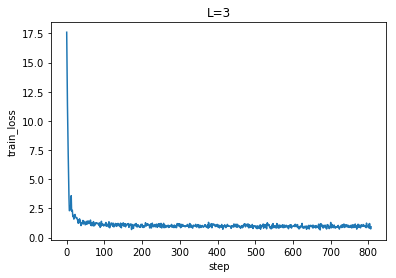

In [81]:
plt.title('L=3')
plt.xlabel('step')
plt.ylabel('train_loss')
plt.plot(losss['train'])

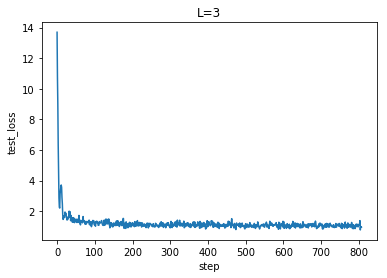

In [82]:
plt.figure()
plt.title('L=3')
plt.xlabel('step')
plt.ylabel('test_loss')
plt.plot(losss['test'])